# Unsupervised Outlier Detection on Heartbeat graphs

I am using Local Outlier Factor (LOF) method and k-nearest neighbors to do anomaly detection on the graph representation of the heart beat signal.

This notebook, is completing the final step of our pipeline and combining the steps and results of <code>MIT-BIH-Kaggle</code> notebook with <code>KNN_AnomalyDetection_OnGraphs</code> to have a complete process from a raw signal to detect anomalies for each heartbeat of the signal using its coresponding graph.

The outlies are the followings:
1. Create graph stream from the original signal.
2. Compute the pairwise distance between each two graphs and produce the distance matrix using Graph edit distance.
3. Feed the distance matrix for our graph stream into a Local Outlier Factor (LOF) model and detect the abnormal graphs (Each graph corespond to a heartbeat).
4. Compare the detected graph with the ground truth, The actual label of the heartbeat is labeled by expert Cardialogists, and compute the accuracy of our model.

## 1. Graph stream from the original signal.
Lets generate our graph stream from the **MIT-BIH** dataset using the helper functions which implemented  in <code>MIT-BIH-Kaggle</code>.

In [36]:
%reload_ext autoreload
%autoreload
%matplotlib inline
from myHelper import timing
from myHelper import GraphSignalHelper

data_df = GraphSignalHelper.read_heartbeat_database(name='100', nRowsRead=65000)
annotations_df = GraphSignalHelper.read_annotation_database(name='100')

# downsampling the signal
downstep = 8
(downsp_data_df, downsp_annotations_df) = GraphSignalHelper.downsample(data_df,
                                                                       annotations_df,
                                                                       downstep)


graph_stream, graph_stream_labels = GraphSignalHelper.generate_graph_stream(downsp_data_df, 
                                                                            downsp_annotations_df, 
                                                                            fs = (360 / downstep))
len(graph_stream)
# 2272

# graph_stream_labels[1]['Type']
# 2    N
# 3    N

221

In [37]:
import networkx as nx
print(nx.info(graph_stream[0]))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 145
Average degree:   8.0556


## 2. Calculate gragh edit distance matrix
Compute the pairwise distance between each two graphs and produce the distance matrix using Graph edit distance.

In [27]:
from myHelper import timing

# Gmatch4py use networkx graph 
import networkx as nx 
# import the GED using the munkres algorithm
import gmatch4py as gm


@timing.time_it
def GED_distance_matrix(graph_series):
    # convert from dictionary of graphs to list of graphs
    graph_stream_list = [v for k, v in graph_stream.items()] 
    ged=gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
    non_symetric_GED_matrix=ged.compare(graph_stream_list,None)
    symetric_ged_matrix = (non_symetric_GED_matrix.transpose()+non_symetric_GED_matrix)/2
    return symetric_ged_matrix

distance_matrix = GED_distance_matrix(graph_stream)
print("precomputed distance matrix =\n",distance_matrix)


GED_distance_matrix took 99258.50796699524   mil sec
precomputed distance matrix =
 [[ 0.  63.  51.5 ... 55.5 51.  63.5]
 [63.   0.  60.  ... 64.  54.  56.5]
 [51.5 60.   0.  ... 47.  35.  65.5]
 ...
 [55.5 64.  47.  ...  0.  50.5 61.5]
 [51.  54.  35.  ... 50.5  0.  66. ]
 [63.5 56.5 65.5 ... 61.5 66.   0. ]]


In [28]:
# np.save('Distance_matrix_223_graph', distance_matrix) # save the file as "Distance_matrix_223_graph.npy" 

## 3. Anomaly detection on graphs using distance matrix
Feed the distance matrix for our graph stream into a Local Outlier Factor (LOF) model and detect the abnormal graphs (Each graph corespond to a heartbeat).

In [29]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=2,
                         algorithm="brute",
                         metric="precomputed",
#                          contamination=0.01, # the proportion of outliers in the data set float 
                         contamination='auto', # the proportion of outliers in the data set float 
                         novelty=False, # novelty=True if you want to use LOF for novelty 
                                        # detection and predict on new unseen data
                         n_jobs=None)

clf.fit(X=distance_matrix)


# predict on training data
# Fits the model to the training set X and returns the labels.
outlier_prediction = clf.fit_predict(X=distance_matrix)
print("outlier prediction (-1 = abnormal, 1 = normal) \n\n",
      outlier_prediction)

# Fit the model using X as training data.
clf.fit(X=distance_matrix)

# Observations having a negative_outlier_factor smaller than offset_ are detected as abnormal.
# The offset is set to -1.5 (inliers score around -1), except when
# a contamination parameter different than “auto” is provided.
print("\n Outlier threshold = ", -(clf.offset_))


# Only available for novelty detection (when novelty is set to True).
# The shift offset allows a zero threshold for being an outlier.
# print("decision_function = ", clf.decision_function(X=symetric_result))


#  negative_outlier_factor_ndarray shape (n_samples,)
#  negative_outlier_factor_ = -1 normal
#  negative_outlier_factor_ << -1 abnormal 
print("\n Outlier scores (1 = normal, 1 >> abnormal)= \n \n", -(clf.negative_outlier_factor_))

outlier prediction (-1 = abnormal, 1 = normal) 

 [ 1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1]

 Outlier threshold =  1.5

 Outlier scores (1 = normal, 1 >> abnormal)= 
 
 [1.09060403 1.07462225 0.99333333 1.06606304 1.01620284 1.28313492
 1.45380633 1.81024984 0.98878272 1.05794486 1.06       1.07971586
 1.10791045 1.00662119 1.0365228  1.0612918  1.08525055 1.0779220

## 4. Evaluation to the ground truth (labels by Cardiologists)
Compare the detected anomaly graphs with the ground truth, The actual label of the heartbeat is labeled by expert Cardialogists, and compute the accuracy of our model.

In [30]:
def ground_truth_labels(graph_stream_labels):
    '''
    Assign the true labels based on the annotations in our database
    1 = Normal heartbeat
    -1 = Anomalous heartbeat
    
    --------------------------------------------------------------------------

    :param graph_stream_labels: a list of dataframes which can contain zero to 
    two rows for each heartbeat annotation.
    
    :return true_labels: list containing the true labels of (1) or (-1)
    '''
    true_labels = []
    for graph_index, graph_annotation in enumerate(graph_stream_labels):
        graph_label = 99999
        if(len(graph_annotation.index) == 1):
            if(graph_annotation.iloc[0]['Type'] == "N"):
                true_labels.append(1)
            else:
                true_labels.append(-1)
        elif (len(graph_annotation.index) == 2):
            if((graph_annotation.iloc[0]['Type'] == "N") and (graph_annotation.iloc[1]['Type'] == "N")):
                true_labels.append(1)
            else:
                true_labels.append(-1)
        elif (len(graph_annotation.index) == 0):
            true_labels.append(-1)
    return true_labels

true_labels = ground_truth_labels(graph_stream_labels)
print(true_labels)


[1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [31]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support


y_true = ground_truth_labels(graph_stream_labels)
y_pred = clf.fit_predict(X=distance_matrix)
print("Confusion matrix = \n", confusion_matrix(y_true, y_pred))
n_errors = (y_pred != y_true).sum()
print('\nNumber of errors = ', n_errors)
print('\naccuracy =' , round(1 - (n_errors / len(y_true)),4))

# #  Note that the ground truth and the y_pred for LOF is different than the original ... inliers = normal = 1 and outliers = fraud = -1
# # We have to modify the y_pred for the F1 score calculation

# y_predLOF = y_pred.copy()
# y_predDF = pd.DataFrame(y_predLOF)
# # print(y_predDF[y_predDF[0] == -1].count())

# y_predDF[y_predDF[0] == 1] = 0
# y_predDF[y_predDF[0] == -1] = 1
# # print(y_predDF[y_predDF[0] == 1].count())

# y_predLOF = y_predDF.values
# y_predLOF = np.ravel(y_predLOF)

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_true, y_pred, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

Confusion matrix = 
 [[  0   1]
 [  1 219]]

Number of errors =  2

accuracy = 0.991
precision  0.9955
recall  0.9955
F1 score on Test 0.9955


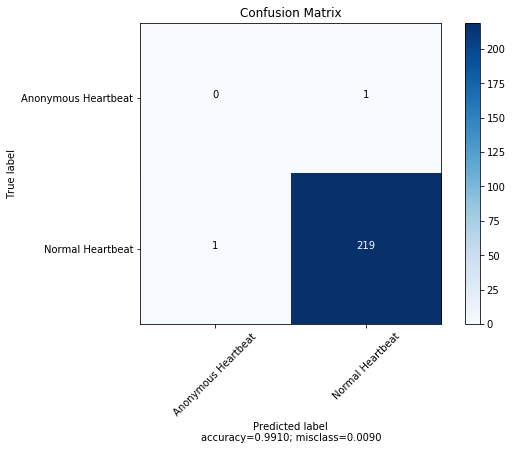

In [32]:
from myHelper import My_confusion_matrix_plotter
My_confusion_matrix_plotter.confusion_matrix_plotter(cm           = confusion_matrix(y_true, y_pred), 
                                                     normalize    = False,
                                                     target_names = ['Anonymous Heartbeat', 'Normal Heartbeat'],
                                                     title        = "Confusion Matrix")

In [33]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('True Negative (Anomalous) = ', tn)
print('False Negative (Anomalous) =', fn)
print('False Positive (Normal)=', fp)
print('True Positive (Normal)=', tp)

True Negative (Anomalous) =  0
False Negative (Anomalous) = 1
False Positive (Normal)= 1
True Positive (Normal)= 219


## Optimize num of neighbors hyper paramter for best F1 score

In [34]:
minRE = 2
maxRE = 40
    
EpsF1 = []
y_true = ground_truth_labels(graph_stream_labels)

for TryRE in range(minRE,maxRE,1):
    clf = LocalOutlierFactor(n_neighbors=TryRE,
                             algorithm="brute",
                             metric="precomputed",
                             contamination='auto', # the proportion of outliers in the data set float 
                             novelty=False, # novelty=True if you want to use LOF for novelty 
                                            # detection and predict on new unseen data
                             n_jobs=None)
    
    y_pred = clf.fit_predict(X=distance_matrix)
    n_errors = (y_pred != y_true).sum()
#     print('\naccuracy =' , round(1 - (n_errors / len(y_true)),4))
    
#     X_scores = clf.negative_outlier_factor_
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
#     print("F1 score on test", round(fbeta_score,4), " with num neighbors ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumNeighb', 'F1'])
EpsF1df.head()

,NumNeighb,F1
0,2,0.9955
1,3,0.9909
2,4,0.9909
3,5,0.9909
4,6,0.9909


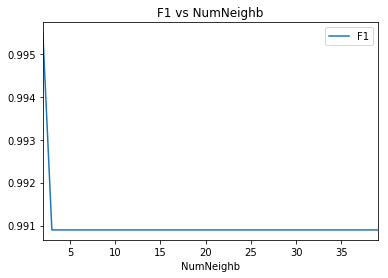

In [35]:
from matplotlib import pyplot as plt
EpsF1df.plot.line("NumNeighb","F1")
plt.xlim(2, 39)
plt.title("F1 vs NumNeighb")
plt.show()

Now I know that the optimal number of neighbors for our case is 2.

## Compute the ROC and AUC

To do:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc